In [1]:
#Match GLORYS profiles with CORA - November 2021
import xarray as xr
import dask
import glob
import pandas as pd
import time
import numpy as np
import time
import matplotlib.pyplot as plt
import gsw
import yaml


#Section with PCs and with Levels
import datetime as dt 
import glob
import netCDF4 as nc
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
import gsw

import yaml

import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xarray as xr
import numpy as np
import pandas as pd



import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = './cartopy_shapefiles'

os.getcwd()

'/home1/datahome/mlejeune'

In [2]:
with open(r'configuration.yaml') as file:
    configuration = yaml.load(file, Loader=yaml.FullLoader)

    print("File version: ", configuration["version"])

File version:  0.1


In [3]:
%%time
dir_path = '/home/ref-ocean-reanalysis/global-reanalysis-phy-001-030-daily/'
file = []

cora = xr.open_dataset(configuration['CORA_OUTPUT'] + configuration['OUTPUT_FILE_NAME'])

CPU times: user 28 ms, sys: 8 ms, total: 36 ms
Wall time: 176 ms


## Extract Glorys12 data

In [9]:
%%time
dir_path = '/home/ref-ocean-reanalysis/global-reanalysis-phy-001-030-daily'
file = []

spatial_domain = {"lon":[configuration['longitude1'], configuration['longitude2']],
                 "lat": [configuration['latitude2'], configuration['latitude1']], "depth": 1100}


yy = "1993"
mm = ["01","02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"];

for yy in range(1993, 1994):
    
    start_time = time.time()

    for mms in mm:
        file = glob.glob(f"{dir_path}/{yy}/{mms}/*_mean_{yy}*.nc")
    
        for files in file:
            day = str(files[106: 108])

            cora_sel = cora.where((cora.TIME.dt.year == int(yy)), drop=True)[['LONGITUDE', 'LATITUDE', 'TIME']]
            ds_full = xr.open_mfdataset(files)

            glorys_sel = ds_full.sel(longitude=slice(spatial_domain['lon'][0], spatial_domain['lon'][1]),
                            latitude=slice(spatial_domain['lat'][0], spatial_domain['lat'][1]),
                            depth=slice(0, spatial_domain['depth']))

            # glorys_sel = glorys_sel.sel(dict(longitude=cora_sel['LONGITUDE'], latitude=cora_sel['LATITUDE'], time=cora_sel['TIME']), method='nearest')
            glorys_sel.to_netcdf(f'/home/datawork-lops-bluecloud/osnet/data_out/bootstrap/OsNet_test_Nordic_Sea/glorys_test/{yy}/GLORYS_{yy}{mms}{day}.nc')
    
        print(f"year {yy} {mms} finished in {time.time() - start_time}")


year 1993 01 finished in 90.21661138534546
year 1993 02 finished in 174.07755208015442
year 1993 03 finished in 266.0295412540436
year 1993 04 finished in 355.89602303504944
year 1993 05 finished in 450.24811577796936
year 1993 06 finished in 537.8050284385681
year 1993 07 finished in 631.1544630527496
year 1993 08 finished in 723.0622534751892
year 1993 09 finished in 816.0940630435944
year 1993 10 finished in 905.7692515850067
year 1993 11 finished in 1001.1683514118195
year 1993 12 finished in 1094.477066040039
CPU times: user 8min 33s, sys: 28.3 s, total: 9min 2s
Wall time: 18min 14s


In [10]:
cora = xr.open_dataset(configuration['CORA_OUTPUT'] + configuration['OUTPUT_FILE_NAME'])
cora = cora.where(cora.TIME.dt.year<=1993
              ,drop = True)
cora = cora.where(cora.TIME.dt.year>=1994,drop = True)
cora.sortby('TIME') 
cora

<xarray.Dataset>
Dimensions:          (N_PROF: 0, DEPTH: 51)
Coordinates:
    LONGITUDE        (N_PROF) float64 
    LATITUDE         (N_PROF) float64 
  * DEPTH            (DEPTH) int64 0 1 2 3 4 5 6 ... 628 697 773 857 950 1000
    TIME             (N_PROF) datetime64[ns] 
Dimensions without coordinates: N_PROF
Data variables: (12/20)
    TEMP_SURF        (N_PROF, DEPTH) float64 
    PSAL_SURF        (N_PROF, DEPTH) float64 
    TEMP             (N_PROF, DEPTH) float64 
    PSAL             (N_PROF, DEPTH) float64 
    DC_REFERENCE     (N_PROF) object 
    PLATFORM_NUMBER  (N_PROF) object 
    ...               ...
    VGOSA            (N_PROF) float64 
    SLA_err          (N_PROF) float64 
    SA               (N_PROF, DEPTH) float64 
    CT               (N_PROF, DEPTH) float64 
    SIG              (N_PROF, DEPTH) float64 
    MLD              (N_PROF) float64

## Interpolation bewteen CORA & Glorys12

In [11]:
%%time

dir_path = '/home1/datahome/mlejeune/assets/Glorys_sel/'
file = []

for yy in np.arange(1993, 1994):
    start_time = time.time()

    file = glob.glob(f"/home/datawork-lops-bluecloud/osnet/data_out/bootstrap/OsNet_test_Nordic_Sea/glorys_test/{yy}/GLORYS_{yy}*.nc")
    
    cora_sel = cora.where((cora.TIME.dt.year == int(yy)), drop=True)[['LONGITUDE', 'LATITUDE', 'TIME']]
    glorys = xr.open_mfdataset(file)

    glorys_sel = glorys.sel(dict(longitude=cora_sel['LONGITUDE'], latitude=cora_sel['LATITUDE'], time=cora_sel['TIME']), method='nearest')
    glorys_sel.to_netcdf(f'/home1/datahome/mlejeune/assets/GLORYS_interp/GLORYS_cora_{yy}.nc')
    print(f"year {yy} finished in {time.time() - start_time}")

RuntimeError: NetCDF: Invalid argument

In [16]:
glorys = xr.open_mfdataset(f'/home1/datahome/mlejeune/assets/GLORYS_interp/GLORYS_*.nc', combine='nested', concat_dim='N_PROF').load()


In [17]:
#Combine
glorys = xr.open_mfdataset(f'/home1/datahome/mlejeune/assets/GLORYS_interp/GLORYS_*.nc', combine='nested', concat_dim='N_PROF').load()
glorys = glorys.sortby('TIME')
cora = cora.sortby('TIME')
glorys

<xarray.Dataset>
Dimensions:    (N_PROF: 3605, depth: 36)
Coordinates:
    longitude  (N_PROF) float32 1.583 1.583 -12.17 -11.92 ... -9.083 2.833 3.417
    latitude   (N_PROF) float32 69.83 69.83 69.0 69.58 ... 69.67 72.25 74.58
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 763.3 902.3 1.062e+03
    time       (N_PROF) datetime64[ns] 2000-05-19T12:00:00 ... 2010-12-31T12:...
    LONGITUDE  (N_PROF) float64 1.615 1.615 -12.2 -11.95 ... -9.107 2.793 3.375
    LATITUDE   (N_PROF) float64 69.85 69.85 69.0 69.57 ... 69.66 72.25 74.61
    TIME       (N_PROF) datetime64[ns] 2000-05-19T22:00:00 ... 2010-12-31T19:...
Dimensions without coordinates: N_PROF
Data variables:
    mlotst     (N_PROF) float32 16.02 16.02 36.62 38.15 ... 151.7 155.5 495.8
    zos        (N_PROF) float32 -0.7498 -0.7498 -0.9238 ... -0.795 -0.8847
    bottomT    (N_PROF) float32 -1.037 -1.037 -0.9037 ... -0.8473 -0.9352 -1.041
    sithick    (N_PROF) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    siconc     (N_PROF) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    usi        (N_PROF) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vsi        (N_PROF) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    thetao     (N_PROF, depth) float32 6.137 6.136 6.135 ... -0.6371 -0.654
    so         (N_PROF, depth) float32 35.16 35.16 35.16 ... 34.9 34.9 34.91
    uo         (N_PROF, depth) float32 0.1434 0.1483 0.152 ... 0.02747 0.02625
    vo         (N_PROF, depth) float32 0.3363 0.3278 ... -0.003052 -0.001831
Attributes: (12/24)
    title:              daily mean fields from Global Ocean Physics Analysis ...
    easting:            longitude
    northing:           latitude
    history:            2017/05/29 22:40:48 MERCATOR OCEAN Netcdf creation
    source:             MERCATOR GLORYS12V1
    institution:        MERCATOR OCEAN
    ...                 ...
    longitude_min:      -180.0
    longitude_max:      179.91667
    latitude_min:       -80.0
    latitude_max:       90.0
    z_min:              0.494025
    z_max:              5727.917

In [18]:
#Save in situ temp and not potential temp
SA_pred = gsw.SA_from_SP(glorys['so'], glorys['depth'], glorys['longitude'], glorys['latitude'])
CT_pred = gsw.CT_from_pt(glorys['so'], glorys['thetao'])
to = gsw.t_from_CT(SA_pred, CT_pred, glorys['depth'])
glorys = glorys.assign(variables={"to": (('N_PROF', 'depth'), to.data)})
glorys

<xarray.Dataset>
Dimensions:    (N_PROF: 3605, depth: 36)
Coordinates:
    longitude  (N_PROF) float32 1.583 1.583 -12.17 -11.92 ... -9.083 2.833 3.417
    latitude   (N_PROF) float32 69.83 69.83 69.0 69.58 ... 69.67 72.25 74.58
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 763.3 902.3 1.062e+03
    time       (N_PROF) datetime64[ns] 2000-05-19T12:00:00 ... 2010-12-31T12:...
    LONGITUDE  (N_PROF) float64 1.615 1.615 -12.2 -11.95 ... -9.107 2.793 3.375
    LATITUDE   (N_PROF) float64 69.85 69.85 69.0 69.57 ... 69.66 72.25 74.61
    TIME       (N_PROF) datetime64[ns] 2000-05-19T22:00:00 ... 2010-12-31T19:...
Dimensions without coordinates: N_PROF
Data variables:
    mlotst     (N_PROF) float32 16.02 16.02 36.62 38.15 ... 151.7 155.5 495.8
    zos        (N_PROF) float32 -0.7498 -0.7498 -0.9238 ... -0.795 -0.8847
    bottomT    (N_PROF) float32 -1.037 -1.037 -0.9037 ... -0.8473 -0.9352 -1.041
    sithick    (N_PROF) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    siconc     (N_PROF) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    usi        (N_PROF) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vsi        (N_PROF) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    thetao     (N_PROF, depth) float32 6.137 6.136 6.135 ... -0.6371 -0.654
    so         (N_PROF, depth) float32 35.16 35.16 35.16 ... 34.9 34.9 34.91
    uo         (N_PROF, depth) float32 0.1434 0.1483 0.152 ... 0.02747 0.02625
    vo         (N_PROF, depth) float32 0.3363 0.3278 ... -0.003052 -0.001831
    to         (N_PROF, depth) float64 6.139 6.138 6.137 ... -0.6021 -0.6113
Attributes: (12/24)
    title:              daily mean fields from Global Ocean Physics Analysis ...
    easting:            longitude
    northing:           latitude
    history:            2017/05/29 22:40:48 MERCATOR OCEAN Netcdf creation
    source:             MERCATOR GLORYS12V1
    institution:        MERCATOR OCEAN
    ...                 ...
    longitude_min:      -180.0
    longitude_max:      179.91667
    latitude_min:       -80.0
    latitude_max:       90.0
    z_min:              0.494025
    z_max:              5727.917

In [19]:
#Interpolate CORA on depth
cora = cora.assign_coords({'depth': glorys.depth})
corai = cora.interp(DEPTH=glorys.depth, method = 'linear')

corai

<xarray.Dataset>
Dimensions:          (N_PROF: 3605, depth: 36)
Coordinates:
    LONGITUDE        (N_PROF) float64 1.615 1.615 -12.2 ... -9.107 2.793 3.375
    LATITUDE         (N_PROF) float64 69.85 69.85 69.0 ... 69.66 72.25 74.61
    TIME             (N_PROF) datetime64[ns] 2000-05-19T22:00:00 ... 2010-12-...
    DEPTH            (depth) float32 0.494 1.541 2.646 ... 763.3 902.3 1.062e+03
  * depth            (depth) float32 0.494 1.541 2.646 ... 763.3 902.3 1.062e+03
Dimensions without coordinates: N_PROF
Data variables: (12/20)
    TEMP_SURF        (N_PROF, depth) float64 nan nan nan ... -0.5255 -0.5545 nan
    PSAL_SURF        (N_PROF, depth) float64 nan nan nan nan ... 34.9 34.9 nan
    TEMP             (N_PROF, depth) float64 5.656 5.656 5.656 ... -0.5545 nan
    PSAL             (N_PROF, depth) float64 35.14 35.14 35.14 ... 34.9 34.9 nan
    DC_REFERENCE     (N_PROF) object b'61675413' b'11318498' ... b'15293404'
    PLATFORM_NUMBER  (N_PROF) object b'LMEL' b'UHQS' ... b'6900601' b'6900801'
    ...               ...
    VGOSA            (N_PROF) float64 0.2398 0.2398 0.0079 ... -0.0066 0.0108
    SLA_err          (N_PROF) float64 0.0207 0.0207 0.009 ... 0.015 0.0135
    SA               (N_PROF, depth) float64 35.3 35.3 35.3 ... 35.07 35.07 nan
    CT               (N_PROF, depth) float64 5.647 5.647 5.647 ... -0.5883 nan
    SIG              (N_PROF, depth) float64 27.71 27.71 27.71 ... 28.06 nan
    MLD              (N_PROF) float64 30.0 30.0 80.0 110.0 ... 245.0 19.0 nan

In [20]:
cora = cora.assign(variables={"TEMP_SURFd": (('N_PROF', 'depth'), corai.TEMP_SURF.data)})
cora = cora.assign(variables={"PSAL_SURFd": (('N_PROF', 'depth'), corai.PSAL_SURF.data)})
cora = cora.assign(variables={"TEMPd": (('N_PROF', 'depth'), corai.TEMP.data)})
cora = cora.assign(variables={"PSALd": (('N_PROF', 'depth'), corai.PSAL.data)})

In [21]:
#Compute SA and CT
SA = gsw.SA_from_SP(cora['PSALd'], cora['depth'], cora['LONGITUDE'], cora['LATITUDE'])
CT = gsw.CT_from_t(cora['PSALd'], cora['TEMPd'], cora['depth'])
SIG = gsw.sigma0(SA,CT)
glorys = glorys.assign(variables={"SA": (('N_PROF', 'depth'), SA.data)})
glorys = glorys.assign(variables={"CT": (('N_PROF', 'depth'), CT.data)})
glorys = glorys.assign(variables={"TEMP": (('N_PROF', 'depth'), corai.TEMP.data)})
glorys = glorys.assign(variables={"PSAL": (('N_PROF', 'depth'), corai.PSAL.data)})
glorys = glorys.assign(variables={"SIG": (('N_PROF', 'depth'), SIG.data)})

#Compute SA and CT predicted
SA_predicted = gsw.SA_from_SP(glorys['so'], glorys['depth'], glorys['longitude'], glorys['latitude'])
CT_predicted = gsw.CT_from_t(glorys['so'], glorys['to'].data, glorys['depth'])
SIG_predicted = gsw.sigma0(SA_predicted,CT_predicted)
glorys = glorys.assign(variables={"SA_predicted": (('N_PROF', 'depth'), SA_predicted.data)})
glorys = glorys.assign(variables={"CT_predicted": (('N_PROF', 'depth'), CT_predicted.data)})
glorys = glorys.assign(variables={"SIG_predicted": (('N_PROF', 'depth'), SIG_predicted.data)})
#

In [22]:
glorys

<xarray.Dataset>
Dimensions:        (N_PROF: 3605, depth: 36)
Coordinates:
    longitude      (N_PROF) float32 1.583 1.583 -12.17 ... -9.083 2.833 3.417
    latitude       (N_PROF) float32 69.83 69.83 69.0 69.58 ... 69.67 72.25 74.58
  * depth          (depth) float32 0.494 1.541 2.646 ... 763.3 902.3 1.062e+03
    time           (N_PROF) datetime64[ns] 2000-05-19T12:00:00 ... 2010-12-31...
    LONGITUDE      (N_PROF) float64 1.615 1.615 -12.2 ... -9.107 2.793 3.375
    LATITUDE       (N_PROF) float64 69.85 69.85 69.0 69.57 ... 69.66 72.25 74.61
    TIME           (N_PROF) datetime64[ns] 2000-05-19T22:00:00 ... 2010-12-31...
Dimensions without coordinates: N_PROF
Data variables: (12/20)
    mlotst         (N_PROF) float32 16.02 16.02 36.62 ... 151.7 155.5 495.8
    zos            (N_PROF) float32 -0.7498 -0.7498 -0.9238 ... -0.795 -0.8847
    bottomT        (N_PROF) float32 -1.037 -1.037 -0.9037 ... -0.9352 -1.041
    sithick        (N_PROF) float32 nan nan nan nan nan ... nan nan nan nan nan
    siconc         (N_PROF) float32 nan nan nan nan nan ... nan nan nan nan nan
    usi            (N_PROF) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...             ...
    TEMP           (N_PROF, depth) float64 5.656 5.656 5.656 ... -0.5545 nan
    PSAL           (N_PROF, depth) float64 35.14 35.14 35.14 ... 34.9 34.9 nan
    SIG            (N_PROF, depth) float64 27.71 27.71 27.71 ... 28.06 28.06 nan
    SA_predicted   (N_PROF, depth) float64 35.32 35.32 35.32 ... 35.07 35.07
    CT_predicted   (N_PROF, depth) float64 6.132 6.131 6.13 ... -0.6345 -0.6513
    SIG_predicted  (N_PROF, depth) float64 27.66 27.66 27.66 ... 28.06 28.07
Attributes: (12/24)
    title:              daily mean fields from Global Ocean Physics Analysis ...
    easting:            longitude
    northing:           latitude
    history:            2017/05/29 22:40:48 MERCATOR OCEAN Netcdf creation
    source:             MERCATOR GLORYS12V1
    institution:        MERCATOR OCEAN
    ...                 ...
    longitude_min:      -180.0
    longitude_max:      179.91667
    latitude_min:       -80.0
    latitude_max:       90.0
    z_min:              0.494025
    z_max:              5727.917

In [23]:
ae_so_surf = xr.ufuncs.fabs(cora['PSAL_SURFd']- glorys['so'])
ae_to_surf = xr.ufuncs.fabs(cora['TEMP_SURFd']- glorys['to'])
ae_SIG = xr.ufuncs.fabs(glorys['SIG']- glorys['SIG_predicted'])

glorys = glorys.assign(variables={"ae_so_surf": (('N_PROF', 'depth'), ae_so_surf.data)})
glorys = glorys.assign(variables={"ae_to_surf": (('N_PROF', 'depth'), ae_to_surf.data)})
glorys = glorys.assign(variables={"ae_SIG": (('N_PROF', 'depth'), ae_SIG.data)})

ae_so = xr.ufuncs.fabs(cora['PSALd']- glorys['so'])
ae_to = xr.ufuncs.fabs(cora['TEMPd']- glorys['to'])
glorys = glorys.assign(variables={"ae_so": (('N_PROF', 'depth'), ae_so.data)})
glorys = glorys.assign(variables={"ae_to": (('N_PROF', 'depth'), ae_to.data)})

Text(0.5, 0.98, 'absolute error between Glorys12 prediction and CORA profiles')

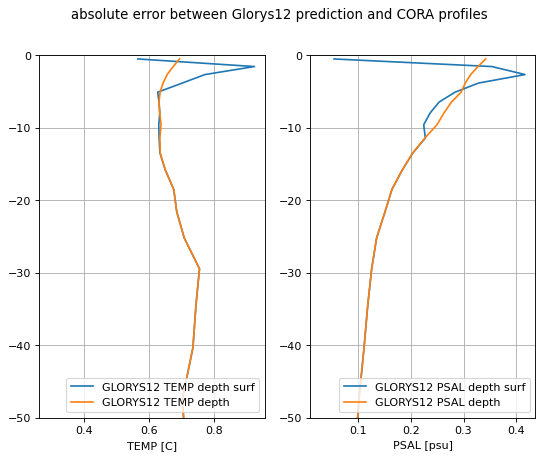

In [24]:
def rmse_from_ae(ae):
    return np.sqrt(((ae) ** 2).mean(axis=0))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
ax[0].plot(rmse_from_ae(glorys['ae_to_surf']), -glorys['depth'], label='GLORYS12 TEMP depth surf')
ax[0].plot(rmse_from_ae(glorys['ae_to']), -glorys['depth'], label='GLORYS12 TEMP depth')
ax[0].set_xlabel('TEMP [C]')
ax[0].set_ylim([-50,0])
ax[0].grid()
ax[0].legend(loc='lower right')

ax[1].plot(rmse_from_ae(glorys['ae_so_surf']), -glorys['depth'], label='GLORYS12 PSAL depth surf')
ax[1].plot(rmse_from_ae(glorys['ae_so']), -glorys['depth'], label='GLORYS12 PSAL depth')
ax[1].set_xlabel('PSAL [psu]')
ax[1].set_ylim([-50,0])
ax[1].grid()
plt.legend(loc='lower right')

fig.suptitle(f'absolute error between Glorys12 prediction and CORA profiles')

In [25]:
glorys.to_netcdf(f'/home1/datahome/mlejeune/assets/GLORYS_interp/GLORYS_Interp_Final.nc')